In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Description du probleme:

Le riz est une culture de base en Égypte, mais malgré la position de l'Égypte en tant que premier producteur de riz en Afrique, le pays dépend toujours des importations pour répondre à la demande de sa population. L'une des principales causes de cet écart en Égypte est la pyriculariose du riz(rice blast disease) , responsable d'une perte de 30 % de la production de riz dans le monde.

La détection précoce est le meilleur moyen de gérer les maladies des cultures comme la pyriculariose du riz, mais la pyriculaire du riz est facilement classée à tort comme maladie des taches brunes ( brown spot disease ) - les deux sont des maladies fongiques et ont des apparences similaires à leur stade précoce. Compte tenu de la pénurie actuelle d'agents de vulgarisation agricole expérimentés dans le pays, il est clair que les récents progrès technologiques en matière de vision par ordinateur pourraient faciliter le diagnostic précoce, notamment en utilisant des images multispectrales des cultures.

L'objectif de ce défi est de prédire la maladie d'un plant de riz en images RVB et Infrarouge. Les meilleures solutions recevront des prix en argent et seront incluses dans une publication conjointe avec les organisateurs.

# Objectif:
prédire la maladie d'un plant de riz en images RVB et Infrarouge

In [4]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchmetrics.classification import Accuracy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

In [5]:
data_train = pd.read_csv("/kaggle/input/data354/Train.csv")
data_test = pd.read_csv("/kaggle/input/data354/Test.csv")
train = data_train.copy()
test = data_test.copy()

In [18]:
train.shape

(5340, 2)

In [19]:
test.shape

(2290, 1)

In [20]:
train.head()

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast


In [21]:
train.isna().sum()

Image_id    0
Label       0
dtype: int64

**Aucune valeur manquante dans le jeu de données**

In [22]:
print(f'dimension: {train.shape}')
print(f'modalite:{(train["Label"]).unique()}')

dimension: (5340, 2)
modalite:['blast' 'brown' 'healthy']


Les differentes modalites à predire sont **blast, brown et healthy**

Comme les images sont dupliquées et qu'on nous demande dans les consignes de n'utiliser qu'un seul type d'image, alors je decide de ne conserver que les **images RVB** et de supprimer les autres.

In [6]:
train = train[~train.Image_id.str.contains('_rgn.jpg')].reset_index(drop=True)
test1 = test[~test.Image_id.str.contains('_rgn.jpg')].reset_index(drop=True)
train.head()

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_005sitfgr2.jpg,brown
2,id_00stp9t6m6.jpg,blast
3,id_012zxewnhx.jpg,blast
4,id_0186qwq2at.jpg,healthy


Apres conservation que des images en RVB, voici les nouvelles dimensions de notre jeu de données

In [24]:
print(train.shape, test1.shape)

(2670, 2) (1145, 1)


Essayons de connaitre **les proportions des differentes classes** de notre jeu de données

In [25]:
print(f"Pourcentage d'échantillons 'healthy': {100 * train[train['Label']=='healthy'].shape[0] / len(train)}%")
print(f"Pourcentage d'échantillons 'brown': {100 * train[train['Label']=='brown'].shape[0] / len(train)}%")
print(f"Pourcentage d'échantillons 'blast': {100 * train[train['Label']=='blast'].shape[0] / len(train)}%")

Pourcentage d'échantillons 'healthy': 15.355805243445692%
Pourcentage d'échantillons 'brown': 28.689138576779026%
Pourcentage d'échantillons 'blast': 55.95505617977528%


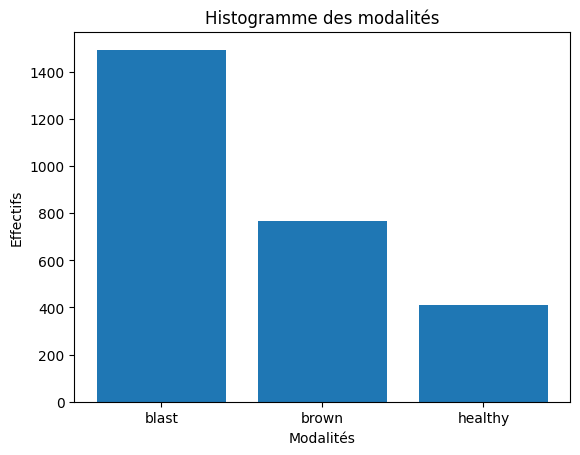

In [26]:
liste = ["blast", "brown", "healthy"]
liste2= [train['Label'].value_counts().get('blast', 0),train['Label'].value_counts().get('brown', 0),train['Label'].value_counts().get('healthy', 0)]

plt.bar(liste, liste2)
plt.xlabel('Modalités')
plt.ylabel('Effectifs')
plt.title('Histogramme des modalités')
plt.show()

Nous jugeons par les resultats obtenus que **nous ne sommes pas dans un cas de données déséquilibrées**

Ma difficulté ici réside dans le fait que mon jeu de donnees **Train.csv** ne contient pas d'images mais plutot les identifiants des differentes images, qui sont elles memes contenues dans un autre dossier. **Je decide alors de faire correspondre chaque identifiant de Train.csv à son image correspondante dans le fichier image.**

In [7]:
chemin = '/kaggle/input/data354/Images/' #chemin des images

train['Image'] = train['Image_id'].apply(lambda x: Image.open(chemin + x))
test['Image'] = test['Image_id'].apply(lambda x: Image.open(chemin + x))

**Encodage de ma variable categorielle cible**:
- blast: 0
- brown: 1
- healthy: 2

In [8]:
#encodage de la variable cible
conditions = {"blast":0,"brown":1,"healthy":2}
train["Label"] = train["Label"].map(conditions)
train.head()

,Image_id,Label,Image
0,id_004wknd7qd.jpg,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,id_005sitfgr2.jpg,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,id_00stp9t6m6.jpg,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,id_012zxewnhx.jpg,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,id_0186qwq2at.jpg,2,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [ ]:
# liste = ["healthy","brown","blast"]
# healthy = train[train['Label']=='healthy'].count()
# brown = train[train['Label']=='brown'].count()
# blast = train[train['Label']=='blast'].count()
# liste1= [healthy,brown,blast]
# # plt.bar(liste,liste1)
# # plt.show()
# print(liste1)

Connaissance de la taille des differentes images **(Important pour l'analyse)**:
Chose qui pourra me permettre de prendre certaine precautions sur les transformations que je deciderai d'en faire.

In [9]:
print(f"taille de l'image:{(train.iloc[2,2]).size}")

taille de l'image:(500, 400)


- J'ai la tailles d'une image bien precise. Cependant, est ce qu'elles ont tous la meme taille ?

**Pour repondre à cette question, je decide de faire une boucle sur train pour m'en assurer**

In [10]:
for i in range(len(train)-1):
    cpt = 0
    if (train.iloc[i,2].size) != (train.iloc[i+1,2].size):
        print(i)
        cpt = cpt + 1
if cpt == 0:
    print("Toutes les images sont de meme taille")
else:
    print("Certaies images ont des tailles differentes")
    

Toutes les images sont de meme taille


In [ ]:
train.iloc[2,2]

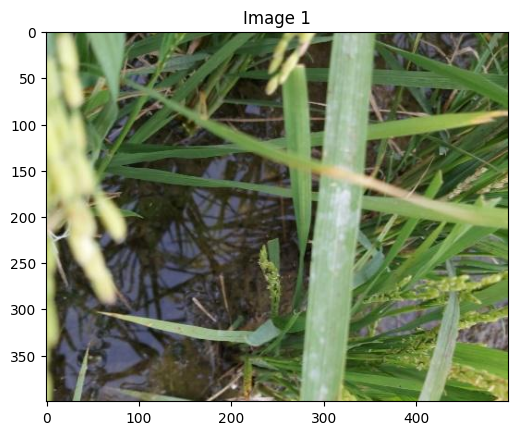

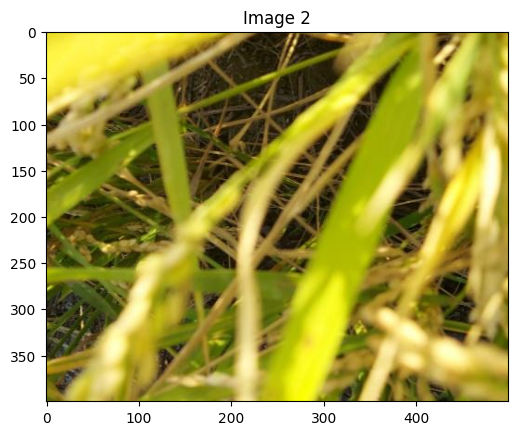

In [11]:
#verifions qu'on a bien des images dans notre jeu de données
for i in range(2):
    # Afficher l'image
    plt.imshow(train['Image'][i])
    plt.title(f"Image {i+1}")
    plt.show()

Je veux faire mon analyse en ne conservant que l'image pour predire l'etat de sante du plant. Car selon moi les identifiants n'auront aucun imapct sur l'analyse. 
**Supprimons donc la caracteristique(Image_id) pour l'analyse**

In [12]:
train = train.drop("Image_id",axis=1)
train.head()

,Label,Image
0,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,2,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [13]:
test = test.drop("Image_id",axis=1)
test.head()

,Image
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...


## Transformation des données dediée à Pytorch

Création d'un ensemble de données propre à Pytorch

In [ ]:
# from torch.utils.data import Dataset
# from PIL import Image

# class CustomDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.data = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         img_name = self.data.iloc[idx, 0]  # Colonne contenant les adresses des images
#         image = Image.open(img_name)

#         if self.transform:
#             image = self.transform(image)

#         label = self.data.iloc[idx, 2]  # Colonne contenant les labels

#         return image, label

In [ ]:
# data_transforms = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

# # Supposons que chemins_images contient des images déjà chargées (au lieu de chemins de fichiers)
# images = list(train["Image"])  # Assurez-vous que "Image" contient des objets image
# etiquettes = list(train["Label"])

# images_transformees = [data_transforms(img) for img in images]
# tenseur_images = torch.stack(images_transformees)
# tenseur_etiquettes = torch.tensor(etiquettes)

# dataset_personnalise = torch.utils.data.TensorDataset(tenseur_images, tenseur_etiquettes)
# train_loader = DataLoader(dataset_personnalise, batch_size=32, shuffle=True)


In [ ]:
# print(train_loader)

In [ ]:
# images_test = list(test["Image"])
# images_test_transformees = [data_transforms(img) for img in images_test]
# tenseur_images = torch.stack(images_test_transformees)

In [15]:
# Définir les transformations des données
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Implementation des modeles

Ici, je vais decider de faire de l'apprentissage par renforcement en utilisant des modeles de bases qui ont été pré- 
entrainé sur ImageNet. Car en vision par ordinateur, il est plus difficile de construire un réseau de neurone en allant
de 0. Ils sont moins performants et moins adaptés en raison des grandes quantites de données qu'ils necessitent pour
leur entrainement.

In [16]:
liste_image = []
liste_label = []
for i in range(len(train)):
    liste_image.append(train.iloc[i, 1])
    liste_label.append(train.iloc[i, 0])

test_image = []
for i in range(len(test)):
    test_image.append(test.iloc[i,0])
    

In [ ]:
liste_image[160]

In [17]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.loc[idx,"images"]  # Colonne 'images'

        label = self.dataframe.loc[idx,"labels"]  # Colonne 'labels'

        if self.transform:
            image = self.transform(image)

        return image, label

# Créer un DataFrame fictif pour l'exemple
data = {'images': liste_image,
        'labels': liste_label}
df = pd.DataFrame(data)

# Utiliser la classe CustomDataset pour créer votre ensemble de données
custom_dataset = CustomDataset(dataframe=df, transform=data_transforms['train'])

# Utiliser un DataLoader pour itérer sur les données
custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=4, shuffle=True, num_workers=4)


In [ ]:
df.loc[0,"images"]

In [ ]:
custom_dataloader

In [ ]:
# Créer une instance de ResNet18 avec une nouvelle tête
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, 512),  # Couche linéaire intermédiaire
    nn.ReLU(),                     # Fonction d'activation (ReLU)
    nn.Dropout(0.3),               # Couche de Dropout pour la régularisation
    nn.Linear(512, 256),            # Nouvelle couche linéaire intermédiaire
    nn.ReLU(),                     # Nouvelle fonction d'activation (ReLU)
    nn.Linear(256, 3)               # Couche de sortie avec 3 classes
)

# Définir la fonction de perte (criterion) et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001)

# Mettre le modèle en mode d'entraînement
resnet18.train()

best_loss = float('inf')

# Entraîner le modèle sur plusieurs époques (itérations sur l'ensemble des données)
num_epochs = 5
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(num_epochs):
    for inputs, labels in custom_dataloader:
        # Mettre les données sur le GPU si disponible
        #inputs, labels = inputs.to(device), labels.to(device)

        # Mettre les gradients à zéro
        optimizer.zero_grad()

        # Passe avant (forward pass)
        outputs = resnet18(inputs)

        # Calculer la perte
        loss = criterion(outputs, labels)

        # Passe arrière (backward pass)
        loss.backward()

        # Mettre à jour les poids
        optimizer.step()

        # Sauvegarder les poids du modèle si la perte sur l'ensemble d'entraînement est la meilleure jusqu'à présent
        if loss < best_loss:
            best_loss = loss
            torch.save(resnet18.state_dict(), 'resnet_model.pth.rar')
    print(f'Epoch_ [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.loc[idx, "images"]  # Assurez-vous que la colonne contient le chemin des images
        if self.transform:
            image = self.transform(image)
        return image

    
data = {'images': test_image}
df = pd.DataFrame(data)
       
# Charger le modèle
resnet18 = models.resnet18(pretrained=False)  # Assurez-vous que le modèle est le même que celui que vous avez utilisé
resnet18.fc = nn.Linear(resnet18.fc.in_features, 3)


# Charger les meilleurs poids
# resnet18.load_state_dict(torch.load('/kaggle/working/resnet_model.pth.rar'))

state_dict = torch.load('/kaggle/working/resnet_model.pth.rar')

# Ajuster manuellement les clés
new_state_dict = {}

for key, value in state_dict.items():
    if key.startswith('fc.'):
        new_key = key.replace('fc.', 'fc')
        new_state_dict[new_key] = value

# Charger le nouveau dictionnaire d'état
resnet18.load_state_dict(new_state_dict, strict=False)

resnet18.eval()

test_dataset = CustomDataset(dataframe=df, transform=data_transforms['val'])  # Assurez-vous que 'val' est le bon type de transformation

# Créer un DataLoader pour le jeu de données de test
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Effectuer les prédictions sur le jeu de données de test
predictions = []
classe = []

with torch.no_grad():
    
    for inputs in test_dataloader:
        
        outputs = resnet18(inputs)
        # Appliquer softmax pour obtenir les probabilités
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0).cpu().numpy()
        # Ajouter les probabilités à la liste des prédictions
        predictions.append(probabilities)
        
        predicted_class = torch.argmax(torch.tensor(probabilities)).item()
        classe.append(predicted_class)
        

        
# Convertir la liste des prédictions en DataFrame
predictions_df = pd.DataFrame(predictions, columns=["blast","brown","healthy"])
result = pd.concat([data_test["Image_id"], predictions_df], axis=1)


# Sauvegarder le DataFrame en tant que fichier CSV
result.to_csv('prediction.csv', index=False)


In [ ]:
r = pd.read_csv("prediction.csv")
r.head()

In [37]:
# Charger VGG16 pré-entraîné
vgg16 = models.vgg16(pretrained=True)

# Congeler les couches pré-entraînées (si nécessaire)
# for param in vgg16.parameters():
#     param.requires_grad = False

# Modifier la tête pour s'adapter à votre tâche de classification
num_classes = 3  # Adapté à votre nombre de classes
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),  # Ajustez ces dimensions en fonction de votre modèle
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 3)        # Ajustez ces dimensions en fonction de votre modèle
)
# Définir la fonction de perte (criterion) et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.001)

# Mettre le modèle en mode d'entraînement
vgg16.train()

best_loss = float('inf')

# Entraîner le modèle sur plusieurs époques (itérations sur l'ensemble des données)
num_epochs = 3
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(num_epochs):
    for inputs, labels in custom_dataloader:
        # Mettre les données sur le GPU si disponible
        #inputs, labels = inputs.to(device), labels.to(device)

        # Mettre les gradients à zéro
        optimizer.zero_grad()

        # Passe avant (forward pass)
        outputs = vgg16(inputs)

        # Calculer la perte
        loss = criterion(outputs, labels)

        # Passe arrière (backward pass)
        loss.backward()

        # Mettre à jour les poids
        optimizer.step()

        # Sauvegarder les poids du modèle si la perte sur l'ensemble d'entraînement est la meilleure jusqu'à présent
        if loss < best_loss:
            best_loss = loss
            torch.save(vgg16.state_dict(), 'vgg16_model.pth.rar')
    print(f'Epoch_ [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch_ [1/3], Loss: 0.8654
Epoch_ [2/3], Loss: 1.1766
Epoch_ [3/3], Loss: 0.0816


In [ ]:
# # Charger VGG16 pré-entraîné
# vgg16 = models.vgg16(pretrained=False)

# # Congeler les couches pré-entraînées (si nécessaire)
# for param in vgg16.parameters():
#     param.requires_grad = False

# # Modifier la tête pour s'adapter à votre tâche de classification
# num_classes = 3  # Adapté à votre nombre de classes
# vgg16.classifier = nn.Sequential(
#     nn.Linear(vgg16.classifier[0].in_features, 512),  # Couche linéaire intermédiaire
#     nn.ReLU(),                     # Fonction d'activation (ReLU)
#     nn.Dropout(0.3),               # Couche de Dropout pour la régularisation
#     nn.Linear(512, 256),            # Nouvelle couche linéaire intermédiaire
#     nn.ReLU(),                     # Nouvelle fonction d'activation (ReLU)
#     nn.Linear(256, num_classes)     # Couche de sortie avec 3 classes
# )

# # Définir la fonction de perte (criterion) et l'optimiseur
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.001)

# # Mettre le modèle en mode d'entraînement
# vgg16.train()

# best_loss = float('inf')

# # Entraîner le modèle sur plusieurs époques (itérations sur l'ensemble des données)
# num_epochs = 5
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# for epoch in range(num_epochs):
#     for inputs, labels in custom_dataloader:
#         # Mettre les données sur le GPU si disponible
#         #inputs, labels = inputs.to(device), labels.to(device)

#         # Mettre les gradients à zéro
#         optimizer.zero_grad()

#         # Passe avant (forward pass)
#         outputs = vgg16(inputs)

#         # Calculer la perte
#         loss = criterion(outputs, labels)

#         # Passe arrière (backward pass)
#         loss.backward()

#         # Mettre à jour les poids
#         optimizer.step()

#         # Sauvegarder les poids du modèle si la perte sur l'ensemble d'entraînement est la meilleure jusqu'à présent
#         if loss < best_loss:
#             best_loss = loss
#             torch.save(vgg16.state_dict(), 'vgg16_model.pth.rar')
#     print(f'Epoch_ [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


In [19]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.loc[idx, "images"]  # Assurez-vous que la colonne contient le chemin des images
        if self.transform:
            image = self.transform(image)
        return image

    
data = {'images': test_image}
df = pd.DataFrame(data)
       
# Charger le modèle
# vgg16 = models.vgg16(pretrained=False)  # Assurez-vous que le modèle est le même que celui que vous avez utilisé
# vgg16.classifier[-1] = nn.Linear(vgg16.classifier[-1].in_features, 3)


# # Charger les meilleurs poids
# vgg16.load_state_dict(torch.load('/kaggle/working/vgg16_model.pth.rar'))

vgg16.classifier[-1] = nn.Linear(vgg16.classifier[-1].in_features, 3)

# Charger le dictionnaire d'état
state_dict = torch.load('/kaggle/working/vgg16_model.pth.rar')

# Ajuster manuellement les clés si nécessaire
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace('classifier.6', 'classifier.6')  # Ajustez en fonction de la structure réelle
    new_state_dict[new_key] = value

# Charger le nouveau dictionnaire d'état
vgg16.load_state_dict(new_state_dict, strict=False)

vgg16.eval()

test_dataset = CustomDataset(dataframe=df, transform=data_transforms['val'])  # Assurez-vous que 'val' est le bon type de transformation

# Créer un DataLoader pour le jeu de données de test
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Effectuer les prédictions sur le jeu de données de test
predictions = []
classe = []

with torch.no_grad():
    
    for inputs in test_dataloader:
        
        outputs = vgg16(inputs)
        # Appliquer softmax pour obtenir les probabilités
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0).cpu().numpy()
        # Ajouter les probabilités à la liste des prédictions
        predictions.append(probabilities)
        
        predicted_class = torch.argmax(torch.tensor(probabilities)).item()
        classe.append(predicted_class)
        

       
        
# Convertir la liste des prédictions en DataFrame
predictions_df = pd.DataFrame(predictions, columns=["blast","brown","healthy"])
result = pd.concat([data_test["Image_id"], predictions_df], axis=1)


# Sauvegarder le DataFrame en tant que fichier CSV
result.to_csv('prediction_vgg16.csv', index=False)


In [3]:
r = pd.read_csv('/kaggle/working/prediction_vgg16.csv')
r.head()

**Conclusion: Apres soumission, je prefere conserver le modele Resnet18**

In [ ]:
# import torch.nn.functional as F

# class Model1(nn.Module):
#     def __init__(self):
#         super(Model1, self).__init__()
#         self.fc1 = nn.Linear(224*224, 128)
#         self.fc2 = nn.Linear(128, 3)

#     def forward(self, x):
#         x = x.view(-1, 224*224)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
# model1 = Model1()    

### Réseau convolutionnel (CNN) simple

In [ ]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 224 * 224, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64 * 224 * 224)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
   
model2 = Model2()   

### Réseau de neurones récurrents (RNN) simple

In [ ]:
# class Model3(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(Model3, self).__init__()
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         h0 = torch.zeros(1, x.size(0), 64).to(x.device)  # Initial hidden state
#         out, _ = self.rnn(x, h0)
#         out = self.fc(out[:, -1, :])  # Take the output from the last time step
#         return out
# model3 = Model3(input_size = 1, hidden_size=64, output_size=1)

### modeles pré-entrainés

In [ ]:
import torch.nn as nn
from torchvision import models

# ResNet18 avec une nouvelle tête
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
resnet18.fc = nn.Linear(resnet18.fc.in_features, 3)  #Remplacez 3 par le nombre de classes dans votre problème

# VGG16 avec une nouvelle tête
#vgg16 = models.vgg16(pretrained=True)
#vgg16.classifier[-1] = nn.Linear(vgg16.classifier[-1].in_features, 3)  # Remplacez 3 par le nombre de classes

# Modèle personnalisé avec une nouvelle tête (remplacez cela par votre propre modèle)

class CustomModel(nn.Module):
    def __init__(self, base_model, input_size, num_classes):
        super(CustomModel, self).__init__()
        self.features = nn.Sequential(
            base_model,
        )
        
        dummy_input = torch.randn(32, 3, 224, 224)  # (batch_size, channels, height, width)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(self.features(dummy_input).view(1, -1).size(1), num_classes),  # Assurez-vous que la taille d'entrée correspond à la sortie du base_model
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.head(x)
        return x


# Utilisez les modèles pré-entraînés avec la classe CustomModel
custom_resnet = CustomModel(base_model=resnet18, input_size=(3, 224, 224), num_classes=3)  # Remplacez 3 par le nombre de classes
#custom_vgg16 = CustomModel(base_model=vgg16, input_size=(3, 224, 224), num_classes=3)  # Remplacez 3 par le nombre de classes

In [ ]:
# class CustomModel(nn.Module):
#     def __init__(self, base_model, input_size, num_classes):
#         super(CustomModel, self).__init__()
#         self.features = nn.Sequential(
#             base_model,
#         )
        
#         # Ajoutez une condition pour traiter les modèles ResNet
#         if isinstance(base_model, models.ResNet):
#             self.head = nn.Sequential(
#                 nn.AdaptiveAvgPool2d((1, 1)),
#                 nn.Flatten(),
#                 nn.ReLU(),
#                 nn.Linear(base_model.fc.in_features, num_classes),
#                 nn.Softmax(dim=1)
#             )
#         else:
#             self.head = nn.Sequential(
#                 nn.AdaptiveAvgPool2d((1, 1)),
#                 nn.Flatten(),
#                 nn.ReLU(),
#                 nn.Linear(base_model.classifier[-1].in_features, num_classes),
#                 nn.Softmax(dim=1)
#             )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.head(x)
#         return x


In [ ]:
# class CustomModel(nn.Module):
#     def __init__(self, base_model, input_size, num_classes):
#         super(CustomModel, self).__init__()
#         self.features = nn.Sequential(
#             base_model,
#         )
#         self.head = nn.Sequential(
#             nn.AdaptiveAvgPool2d((2,2)),
#             nn.Flatten(),
#             nn.ReLU(),
#             nn.Linear(1,3),  # Assurez-vous que la taille d'entrée correspond à la sortie du base_model
#             nn.Softmax(dim=3)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.head(x) 
#         return x